In [1]:
# Install the libraries
!pip install sentence_transformers
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install matplotlib

In [5]:
# Import the packages
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
from sklearn.manifold import TSNE
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_validate
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC
from tensorflow import keras
from tensorflow.keras import layers


In [4]:
!pip install tf-keras

  Using cached tf_keras-2.17.0-py3-none-any.whl.metadata (1.6 kB)
Using cached tf_keras-2.17.0-py3-none-any.whl (1.7 MB)


In [7]:
# Load the embedding model
model = SentenceTransformer("all-MiniLM-L6-v2")

In [8]:
# Load the datasets and create embeddings
file_path = r"data\input data\IU-GroundTruth.csv"
report_column = 'REPORT'
df = pd.read_csv(file_path)
allReports = df[report_column]
allEmbeddings = [];

for report in allReports:
    response = model.encode(report)
    allEmbeddings.append(response)

label_columns = ['Enlarged Cardiom.','Cardiomegaly','Lung Lesion','Lung Opacity','Edema','Consolidation','Pneumonia','Atelectasis','Pneumothorax','Pleural Effusion','Pleural Other','Fracture','Support Devices']
labels = df[label_columns].values

allEmbeddings = np.array(allEmbeddings)
labels = np.array(labels)

# Federated Learning with Surgical Aggregation

## Setup

In [9]:
# Function to create an MLP classifier
def create_mlp_model(input_dim, output_dim):
    model = Sequential()

    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(512, activation="relu")(inputs)
    x = layers.Dropout(0.2)(x) # optional dropout
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.2)(x) # optional dropout
    outputs = layers.Dense(output_dim, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)



    # Compile model
    model.compile(optimizer=Adam(),
                  loss=BinaryCrossentropy(),
                  metrics=[AUC(name='auc')])  # Use AUC as a metric

    return model

In [10]:
# Surgical Aggregation

def surgical_aggregation(nodes, max_label, global_model):

  """
  This function will surgically aggregate the last layer
  with the assumption that all the other layers
  are part of the representation block.

  Args:
    nodes: list of nodes with their models and label indices
    max_label: maximum number of labels / maximum label indice
    global_model: global model to update

  """

  # Extract the models and label indices from each node
  models = [node['classifier'] for node in nodes]
  labels = [node['label_names'] for node in nodes]

  # Identify the common and unique classes across all the models

  # Create a global final layer with all the labels
  lw = models[0].layers[-1].get_weights() # Get the last layer from one of the models
  row_shape = lw[0].shape[0] # Get the shape of the last layer
  final_layer_w = np.zeros((lw[0].shape[0],max_label+1)) # Use the last layer's shape to initialize the final layer for the global model
  final_layer_b = np.zeros(max_label+1) # Same for the bias

  node_count = np.zeros(max_label+1) # Number of contributing to each label



  num_layers = len(models[0].layers) # Get the number of layers
  for iter,layer in enumerate(models[0].layers): # iteratre through all the layers

    if isinstance(layer, tf.keras.layers.Dense): # Check if the layer type is a dense layer

      if iter == num_layers-1: # Check if this is the final layer (for surgical aggregation)

        # Surgically Aggregate the final layer


        node_count = np.zeros(max_label+1) # Initialize an array to count the number of nodes contributing to each label
        for iter1,model in enumerate(models): # iterate through all the models
          w = (model.layers[iter].get_weights()) # get the weights for the last layer
          w_0 = w[0] # get the weight matrix
          w_1 = w[1] # get the bias array

          for l_iter,l in enumerate(labels[iter1]): #iterate through all the labels in this model

            final_layer_w[:,l] += w_0[:,l_iter] # FedAvg on each label this model is contributing to
            final_layer_b[l] += w_1[l_iter]
            node_count[l] += 1

        for l in range(max_label+1):
          if node_count[l] > 0: # if this label has atleast one contributor
            final_layer_w[:,l] /= node_count[l] # perform fedavg
            final_layer_b[l] /= node_count[l] # perform fedavg

        for iter1,model in enumerate(models):
          fw = final_layer_w[:,labels[iter1]] # reassign the weights to each model
          fb = final_layer_b[labels[iter1]]
          model.layers[iter].set_weights([fw,fb])
        global_model.layers[iter].set_weights([final_layer_w,final_layer_b]) # assign the weights to the global model

      else:
        # Normal FedAvg for all other layers
        d_w = [] # for weights
        d_b = [] # for bias
        for model in models:
          d1 = model.layers[iter].get_weights()
          d_w.append(d1[0])
          d_b.append(d1[1])

        new_w = np.mean(d_w,axis=0)
        new_b = np.mean(d_b,axis=0)
        new_d = [new_w,new_b]

        for model in models:
          model.layers[iter].set_weights(new_d)
        global_model.layers[iter].set_weights(new_d)

  # Reassign the models to nodes
  for iter,node in enumerate(nodes):
    node['classifier'] = models[iter]

  return global_model, nodes

In [11]:
# Function to create the datasets for FL
def create_FL_Datasets(X_train, y_train, n_nodes, labels_shared):


  # Initialize the sample and label indices
  sample_indices = np.arange(0, X_train.shape[0])
  label_indices = np.arange(0, y_train.shape[1])

  # Let's shuffle the indices
  np.random.shuffle(label_indices)
  np.random.shuffle(sample_indices)

  # Picking the shared labels
  if labels_shared > 0:
    shared_labels = label_indices[:labels_shared]
    label_indices = label_indices[labels_shared:]
  else:
    shared_labels = []



  # Split the remaining labels into different nodes.
  label_indices_per_node = np.array_split(label_indices, n_nodes)


  # Split the dataset into different nodes
  sample_indices_per_node = np.array_split(sample_indices, n_nodes)

  # Let's create the nodes. Each node will store a dictionary of X_train, y_train,
  # and label_names
  nodes = []
  for i in range(n_nodes):
    node = {}
    node['X_train'] = X_train[sample_indices_per_node[i]]
    if len(shared_labels) > 0:
      node['y_train'] = y_train[np.ix_(sample_indices_per_node[i],np.concatenate((shared_labels,label_indices_per_node[i])))]
      node['label_names'] = np.concatenate((shared_labels,label_indices_per_node[i]))
    else:
      node['y_train'] = y_train[np.ix_(sample_indices_per_node[i],label_indices_per_node[i])]
      node['label_names'] = label_indices_per_node[i]

    node['classifier'] = create_mlp_model(node['X_train'].shape[1], node['y_train'].shape[1])
    nodes.append(node)

  return nodes






In [12]:
# Function to evaluate metrics for a model

def get_metrics(global_model, X_test, y_test, labels):

  import numpy as np
  from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, recall_score, roc_curve

  # Run the global model on the test set
  y_test_predict = global_model.predict(X_test)

  # Create an empty dataframe to store all the values
  df_metrics = {'Disease Label':[], 'Optimal Threshold':[],'Accuracy':[], 'Sensitivity':[], 'Specificity':[], 'AUC':[]}

  # Extract the probability of the disease we are interested in
  for disease_label in range(labels.shape[1]):
    #print(f"Disease Label: {label_columns[disease_label]}")

    y_prob = y_test_predict[:, disease_label]  # Assuming second column is the probability for class 1
    y_true = y_test[:, disease_label]

    # Calculate the ROC curve to find optimal threshold
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)

    # Calculate Youden's J statistic for each threshold
    J = tpr - fpr
    optimal_idx = np.argmax(J)
    optimal_threshold = thresholds[optimal_idx]

    #print(f"Optimal Threshold: {optimal_threshold:.4f}")


    # Apply the optimal threshold to get binary predictions
    y_pred_optimal = (y_prob >= optimal_threshold).astype(int)

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred_optimal)
    #print(f"Accuracy: {accuracy:.4f}")

    # Sensitivity (Recall for the positive class)
    sensitivity = recall_score(y_true, y_pred_optimal, pos_label=1)
    #print(f"Sensitivity: {sensitivity:.4f}")

    # Specificity: True Negative Rate (specificity = TN / (TN + FP))
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_optimal).ravel()
    specificity = tn / (tn + fp)
    #print(f"Specificity: {specificity:.4f}")

    # AUC (Area Under the ROC Curve)
    auc = roc_auc_score(y_true, y_prob)
    #print(f"AUC: {auc:.4f}")

    df_metrics['Disease Label'].append(label_columns[disease_label])
    df_metrics['Optimal Threshold'].append(optimal_threshold)
    df_metrics['Accuracy'].append(accuracy)
    df_metrics['Sensitivity'].append(sensitivity)
    df_metrics['Specificity'].append(specificity)
    df_metrics['AUC'].append(auc)




  df_metrics = pd.DataFrame(df_metrics)
  print(df_metrics)

  return df_metrics



## Experiment 1: Varying the number of nodes

In [13]:
# Federated Learning Experiment

# Create train and test sets
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(allEmbeddings, labels, test_size=test_size, random_state=42)

# Input parameters

labels_shared = 0

num_epochs = 1
num_rounds = 20

allGlobalModels = []
allPerf = []
allLabelNames = []
allMetrics = []

for n_nodes in range(2, 11):

  # Create FL datasets
  nodes = create_FL_Datasets(X_train, y_train, n_nodes, labels_shared)

  # Initialize the global model
  global_model = create_mlp_model(allEmbeddings.shape[1], labels.shape[1])
  max_label = labels.shape[1]-1
  perf = global_model.evaluate(X_test,y_test)

  ### Perform federated learning
  # Iteratively train all models for N epochs and merge them using surgical aggregation

  for round in range(num_rounds):
    for node in nodes:
      node['classifier'].fit(node['X_train'], node['y_train'], epochs=num_epochs, verbose=0)

    print (n_nodes,round)

    # surgical aggregation FL
    global_model, nodes = surgical_aggregation(nodes, max_label, global_model)

  perf = global_model.evaluate(X_test,y_test)
  allGlobalModels.append(global_model)
  allPerf.append(perf)
  label_names = [node['label_names'] for node in nodes]
  allLabelNames.append(label_names)
  allMetrics.append(get_metrics(global_model, X_test, y_test, labels))

  print("performance of the global model after training: AUC=",perf[1], "Loss=", perf[0])

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.3111 - loss: 0.6875 
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - auc: 0.9711 - loss: 0.0912
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
        Disease Label  Optimal Threshold  Accuracy  Sensitivity  Specificity  \
0   Enlarged Cardiom.           0.054925  0.915416     0.924051     0.914373   
1        Cardiomegaly           0.124354  0.972715     0.937500     0.976084   
2         Lung Lesion           0.422850  0.919509     0.915556     0.921260   
3        Lung Opacity           0.419831  0.935880     0.958904     0.926070   
4               Edema           0.047454  0.968622     1.000000     0.968188   
5       Consolidation           0.002239  0.814461     1.000000     0.813443   
6           Pneumonia           0.005996  0.894952     1.000000     0.893793   
7         Atelectasis           0.103623  0.953615     0.958333     0.953285   
8        Pn

In [14]:
# Train and evaluate the base model
base_model = create_mlp_model(allEmbeddings.shape[1], labels.shape[1])

base_model.fit(X_train, y_train, epochs=20, verbose=0)
base_perf = base_model.evaluate(X_test,y_test)
base_metrics = get_metrics(base_model, X_test, y_test, labels)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - auc: 0.9755 - loss: 0.0878 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
        Disease Label  Optimal Threshold  Accuracy  Sensitivity  Specificity  \
0   Enlarged Cardiom.           0.080196  0.939973     0.886076     0.946483   
1        Cardiomegaly           0.044721  0.959072     0.921875     0.962631   
2         Lung Lesion           0.042979  0.918145     0.937778     0.909449   
3        Lung Opacity           0.034993  0.927694     0.972603     0.908560   
4               Edema           0.022327  0.971351     1.000000     0.970954   
5       Consolidation           0.005992  0.918145     1.000000     0.917695   
6           Pneumonia           0.047254  0.974079     1.000000     0.973793   
7         Atelectasis           0.031862  0.934516     0.979167     0.931387   
8        Pneumothorax           0.007670  0.930423     1.000000     0.929849   
9    Pleural Effusion           0.011487  0.893588     1.000000     0.888252   
10      Ple

In [15]:
# Plot AUC vs. number of nodes using seaborn
perf_AUC = [x[1] for x in allPerf]
n_nodes = range(2,11)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Plot the array using seaborn's lineplot
sns.lineplot(x=n_nodes, y=perf_AUC,label='Federated Learning')
sns.lineplot(x=n_nodes, y=[base_perf[1]]*len(n_nodes),label='Base Model')

# Add labels and title
plt.xlabel('Number of Nodes')
plt.ylabel('AUC')
plt.title('AUC vs Number of Nodes')
plt.ylim(0.5, 1)
# Display the plot
plt.show()

ModuleNotFoundError: No module named 'seaborn'

: 

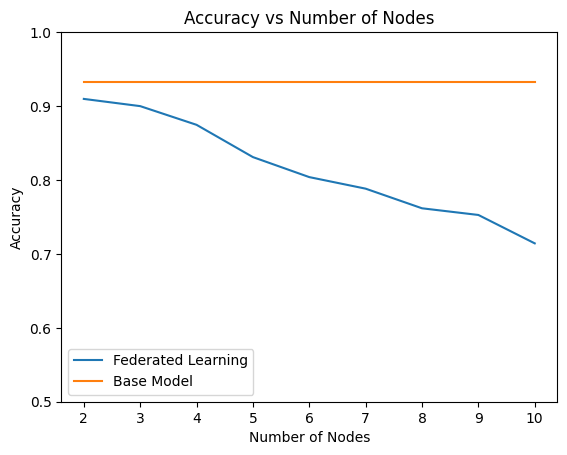

In [12]:
# Mean Accuracy vs. number of nodes
np.mean(allMetrics[0]['Accuracy'])

perf_Accuracy = [np.mean(x['Accuracy']) for x in allMetrics]

# Plot the array using seaborn's lineplot
sns.lineplot(x=n_nodes, y=perf_Accuracy,label='Federated Learning')
sns.lineplot(x=n_nodes, y=[np.mean(base_metrics['Accuracy'])]*len(n_nodes),label='Base Model')

# Add labels and title
plt.xlabel('Number of Nodes')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Nodes')
plt.ylim(0.5, 1)
# Display the plot
plt.show()


In [13]:
# Save all the results as npy files
np.save('allGlobalModels.npy', allGlobalModels)
np.save('allPerf.npy', allPerf)
#np.save('allLabelNames.npy', allLabelNames)
np.save('allMetrics.npy', allMetrics)

np.save('base_perf.npy', base_perf)
np.save('base_model.npy', base_model)
np.save('base_metrics.npy', base_metrics)

